## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 6 slices in the middle
* slide inference

In [1]:
# !pip install -q ../input/pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
# !pip install -q ../input/pytorch-segmentation-models-lib/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
# !pip install -q ../input/pytorch-segmentation-models-lib/timm-0.4.12-py3-none-any.whl
# !pip install -q ../input/pytorch-segmentation-models-lib/segmentation_models_pytorch-0.2.0-py3-none-any.whl

In [2]:
# !mkdir -p /root/.cache/torch/hub/checkpoints/
# !cp ../input/efficientnet-b0-355c32eb.pth /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth

In [3]:
# !pip install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio===0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [4]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime

In [5]:
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

In [6]:
import segmentation_models_pytorch as smp

In [7]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

## config

In [8]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # comp_dir_path = './'
    comp_dir_path = '../input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'resnet-exp025'#'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    # backbone = 'efficientnet-b0'
    # backbone = 'se_resnext101_32x4d'
    backbone = 'se_resnext50_32x4d'

    in_chans = 6 # 65
    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 16 # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 30 # 15

    # adamW warmupあり
    warmup_factor = 10
    # lr = 1e-4 / warmup_factor
    lr = 1e-4 / warmup_factor

    # ============== fold =============
    valid_id = 1

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'../output/{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'

    figures_dir = outputs_path + 'figures/'

    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [ #https://www.kaggle.com/competitions/hubmap-kidney-segmentation/discussion/238013
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.RandomRotate90(),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.9,
                         border_mode=cv2.BORDER_REFLECT),
        A.OneOf([
            A.ElasticTransform(p=.3),
            A.GaussianBlur(p=.3),
            A.GaussNoise(p=.3),
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
            A.IAAPiecewiseAffine(p=0.3),
        ], p=0.3),
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3,p=0.3),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]


set dataset path


/opt/conda/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:299: FutureWarning: This IAAPiecewiseAffine is deprecated. Please use PiecewiseAffine instead
  warnings.warn("This IAAPiecewiseAffine is deprecated. Please use PiecewiseAffine instead", FutureWarning)


## helper

In [9]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [11]:
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

In [12]:
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    # set_env_name()
    # set_dataset_path(cfg)

    if mode == 'train':
        make_dirs(cfg)

In [13]:
cfg_init(CFG)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------


## image, mask

In [14]:
def read_image_mask(fragment_id):

    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - CFG.in_chans // 2
    end = mid + CFG.in_chans // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)

    mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
    mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = mask.astype('float32')
    mask /= 255.0
    
    return images, mask

In [15]:
def get_train_valid_dataset():
    train_images = []
    train_masks = []

    valid_images = []
    valid_masks = []
    valid_xyxys = []

    for fragment_id in range(1, 4):

        image, mask = read_image_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
                # xyxys.append((x1, y1, x2, y2))
        
                if fragment_id == CFG.valid_id:
                    valid_images.append(image[y1:y2, x1:x2])
                    valid_masks.append(mask[y1:y2, x1:x2, None])

                    valid_xyxys.append([x1, y1, x2, y2])
                else:
                    train_images.append(image[y1:y2, x1:x2])
                    train_masks.append(mask[y1:y2, x1:x2, None])

    return train_images, train_masks, valid_images, valid_masks, valid_xyxys

In [16]:
train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset()

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [17]:
# valid_xyxys = np.stack(valid_xyxys)

## dataset

In [18]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [19]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list,p=1.0)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list,p=1.0)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.df)
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']

        return image, label

In [20]:

train_dataset = CustomDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
valid_dataset = CustomDataset(
    valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                          )
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


In [21]:
train_dataset[0][0].shape

torch.Size([6, 224, 224])

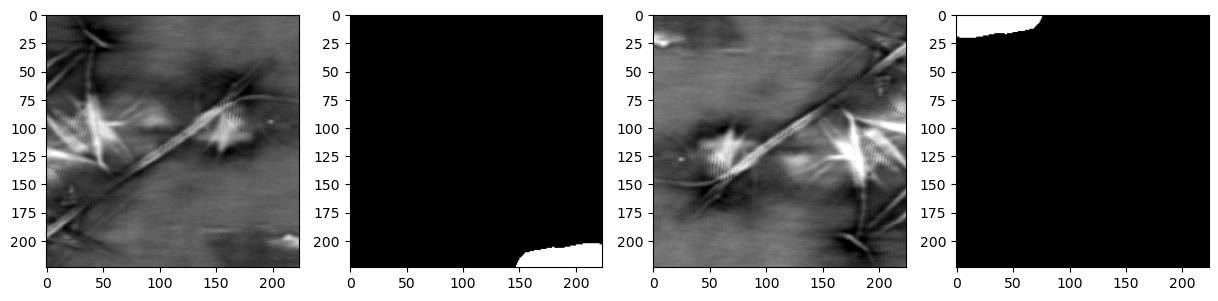

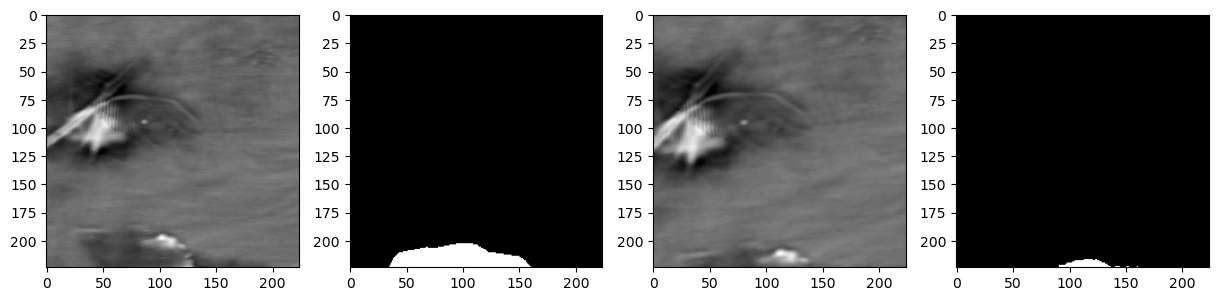

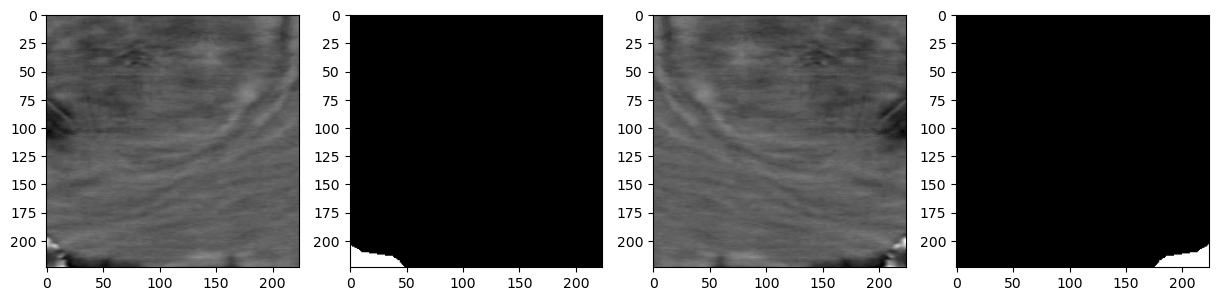

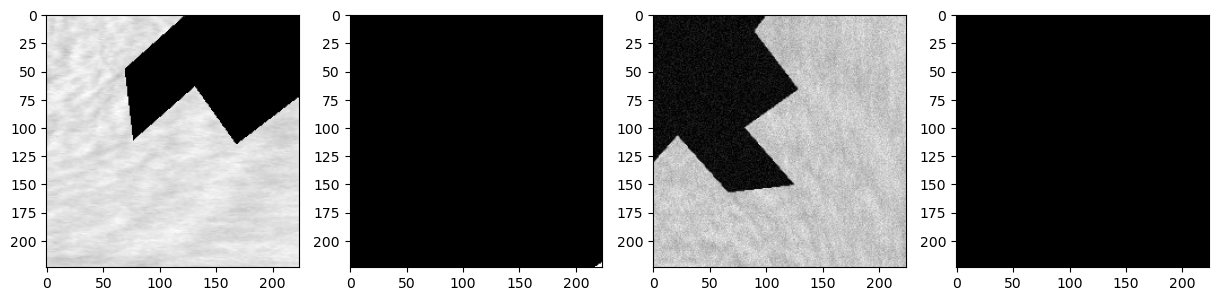

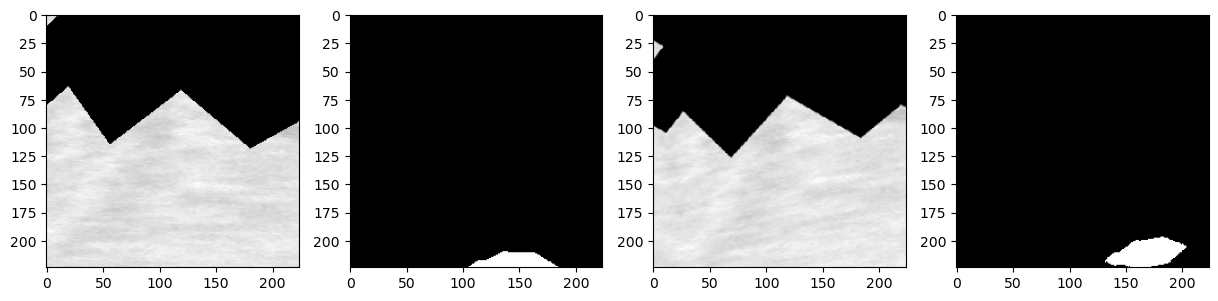

In [22]:

plot_dataset = CustomDataset(
    train_images, CFG, labels=train_masks)

transform = CFG.train_aug_list
transform = A.Compose(
    [t for t in transform if not isinstance(t, (A.Normalize, ToTensorV2))])


plot_count = 0
for i in range(1000):

    image, mask = plot_dataset[i]
    data = transform(image=image, mask=mask)
    aug_image = data['image']
    aug_mask = data['mask']

    if mask.sum() == 0:
        continue

    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    axes[0].imshow(image[..., 0], cmap="gray")
    axes[1].imshow(mask, cmap="gray")
    axes[2].imshow(aug_image[..., 0], cmap="gray")
    axes[3].imshow(aug_mask, cmap="gray")
    
    plt.savefig(CFG.figures_dir + f'aug_fold_{CFG.valid_id}_{plot_count}.png')

    plot_count += 1
    if plot_count == 5:
        break

In [23]:
del plot_dataset
gc.collect()

48120

## model

In [24]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output


def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)

    return model

In [25]:
# def build_model():
#     model = smp.Unet(
#         encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#         encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
#         in_channels=CFG.in_chans,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#         classes=CFG.target_size,        # model output channels (number of classes in your dataset)
#         activation=None,
#     )
#     model.to(CFG.device)
#     return model

# def load_model(path):
#     model = build_model()
#     model.load_state_dict(torch.load(path))
#     model.eval()
#     return model

## scheduler

In [26]:

import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)


In [27]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [28]:
model = build_model(CFG)
model.to(device)

optimizer = AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

model_name Unet
backbone se_resnext50_32x4d


## loss

In [29]:

DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    return BCELoss(y_pred, y_true)
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

## train, val

In [30]:
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    mask_pred = np.zeros(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    return losses.avg, mask_pred

## metrics

In [31]:
from sklearn.metrics import fbeta_score

def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 50+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

## main

In [32]:
fragment_id = CFG.valid_id

valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
valid_mask_gt = valid_mask_gt / 255
pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

In [33]:

fold = CFG.valid_id

if CFG.metric_direction == 'minimize':
    best_score = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1

best_loss = np.inf

for epoch in range(CFG.epochs):

    start_time = time.time()

    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

    # eval
    avg_val_loss, mask_pred = valid_fn(
        valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)

    scheduler_step(scheduler, avg_val_loss, epoch)

    best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)

    # score = avg_val_loss
    score = best_dice

    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
    Logger.info(
        f'Epoch {epoch+1} - avgScore: {score:.4f}')

    if CFG.metric_direction == 'minimize':
        update_best = score < best_score
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score

    if update_best:
        best_loss = avg_val_loss
        best_score = score

        Logger.info(
            f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
        torch.save({'model': model.state_dict(),
                    'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, fbeta: 0.12096601232093039
th: 0.15, fbeta: 0.12097048749103521
th: 0.2, fbeta: 0.12805782832943374
th: 0.25, fbeta: 0.22239874036276974
th: 0.3, fbeta: 0.27465971715406523
th: 0.35, fbeta: 0.31951174480448574
th: 0.4, fbeta: 0.35979978037214727
th: 0.45, fbeta: 0.3883890262880269


best_th: 0.5, fbeta: 0.4019119274932257
Epoch 1 - avg_train_loss: 0.5749  avg_val_loss: 0.3995  time: 152s
Epoch 1 - avgScore: 0.4019
Epoch 1 - Save Best Score: 0.4019 Model
Epoch 1 - Save Best Loss: 0.3995 Model


th: 0.5, fbeta: 0.4019119274932257


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.12097648382339604
th: 0.15, fbeta: 0.208455166631034
th: 0.2, fbeta: 0.2668156631785369
th: 0.25, fbeta: 0.3202568083513614
th: 0.3, fbeta: 0.3514880720352033
th: 0.35, fbeta: 0.3777861120872002
th: 0.4, fbeta: 0.40126698393317034
th: 0.45, fbeta: 0.42143738105675765


best_th: 0.5, fbeta: 0.437262637295627
Epoch 2 - avg_train_loss: 0.3821  avg_val_loss: 0.3317  time: 155s
Epoch 2 - avgScore: 0.4373
Epoch 2 - Save Best Score: 0.4373 Model
Epoch 2 - Save Best Loss: 0.3317 Model


th: 0.5, fbeta: 0.437262637295627


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:715: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


th: 0.1, fbeta: 0.42497281069205184
th: 0.15, fbeta: 0.4714833628099483
th: 0.2, fbeta: 0.46323031285092986
th: 0.25, fbeta: 0.4497839670243442
th: 0.3, fbeta: 0.428301282717641
th: 0.35, fbeta: 0.3939975797761507
th: 0.4, fbeta: 0.3559292887606539
th: 0.45, fbeta: 0.32372832213428177


best_th: 0.15, fbeta: 0.4714833628099483
Epoch 3 - avg_train_loss: 0.2926  avg_val_loss: 0.2909  time: 156s
Epoch 3 - avgScore: 0.4715
Epoch 3 - Save Best Score: 0.4715 Model
Epoch 3 - Save Best Loss: 0.2909 Model


th: 0.5, fbeta: 0.29055551816130826


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.32187224420654664
th: 0.15, fbeta: 0.36779845829303126
th: 0.2, fbeta: 0.4099502155417349
th: 0.25, fbeta: 0.4463994601955244
th: 0.3, fbeta: 0.4793281071667149
th: 0.35, fbeta: 0.5025886696528169
th: 0.4, fbeta: 0.5070118192042706
th: 0.45, fbeta: 0.4849925028887026


best_th: 0.4, fbeta: 0.5070118192042706
Epoch 4 - avg_train_loss: 0.2527  avg_val_loss: 0.2280  time: 157s
Epoch 4 - avgScore: 0.5070
Epoch 4 - Save Best Score: 0.5070 Model
Epoch 4 - Save Best Loss: 0.2280 Model


th: 0.5, fbeta: 0.4315556094146457


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.34856482275461187
th: 0.15, fbeta: 0.38075159040219564
th: 0.2, fbeta: 0.4136856183098866
th: 0.25, fbeta: 0.44507796514620396
th: 0.3, fbeta: 0.47694985862868866
th: 0.35, fbeta: 0.5015012766904156
th: 0.4, fbeta: 0.5183855898088977
th: 0.45, fbeta: 0.5313381109132455


best_th: 0.5, fbeta: 0.5387159380080985
Epoch 5 - avg_train_loss: 0.2365  avg_val_loss: 0.2306  time: 156s
Epoch 5 - avgScore: 0.5387
Epoch 5 - Save Best Score: 0.5387 Model
Epoch 5 - Save Best Loss: 0.2306 Model


th: 0.5, fbeta: 0.5387159380080985


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.34447600439128984
th: 0.15, fbeta: 0.3793917032424922
th: 0.2, fbeta: 0.413343001509034
th: 0.25, fbeta: 0.4450809326966378
th: 0.3, fbeta: 0.472460477823167
th: 0.35, fbeta: 0.4955909349692498
th: 0.4, fbeta: 0.5163919494854093
th: 0.45, fbeta: 0.5334682162458514


best_th: 0.5, fbeta: 0.546684543471493
Epoch 6 - avg_train_loss: 0.2237  avg_val_loss: 0.2298  time: 154s
Epoch 6 - avgScore: 0.5467
Epoch 6 - Save Best Score: 0.5467 Model
Epoch 6 - Save Best Loss: 0.2298 Model


th: 0.5, fbeta: 0.546684543471493


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3440957705083597
th: 0.15, fbeta: 0.3679741683581231
th: 0.2, fbeta: 0.39071526253534616
th: 0.25, fbeta: 0.41177453570093275
th: 0.3, fbeta: 0.43103372672931656
th: 0.35, fbeta: 0.4485735308209103
th: 0.4, fbeta: 0.4638873231463546
th: 0.45, fbeta: 0.47866561403454677


best_th: 0.5, fbeta: 0.4893151194986424
Epoch 7 - avg_train_loss: 0.2102  avg_val_loss: 0.2613  time: 156s
Epoch 7 - avgScore: 0.4893


th: 0.5, fbeta: 0.4893151194986424


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.33468462959018885
th: 0.15, fbeta: 0.3775215449001449
th: 0.2, fbeta: 0.4169376317966486
th: 0.25, fbeta: 0.44748301666165197
th: 0.3, fbeta: 0.4692129475848471
th: 0.35, fbeta: 0.4884223331602544
th: 0.4, fbeta: 0.5010902701967656
th: 0.45, fbeta: 0.5072475513449045


best_th: 0.5, fbeta: 0.5110792859546855
Epoch 8 - avg_train_loss: 0.1976  avg_val_loss: 0.2414  time: 156s
Epoch 8 - avgScore: 0.5111


th: 0.5, fbeta: 0.5110792859546855


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.40242148867985766
th: 0.15, fbeta: 0.4370894072734317
th: 0.2, fbeta: 0.46570804012583905
th: 0.25, fbeta: 0.48837122440877967
th: 0.3, fbeta: 0.5055370056443605
th: 0.35, fbeta: 0.5218248146497482
th: 0.4, fbeta: 0.5328667005813345
th: 0.45, fbeta: 0.5403912972965002


best_th: 0.45, fbeta: 0.5403912972965002
Epoch 9 - avg_train_loss: 0.1859  avg_val_loss: 0.2524  time: 156s
Epoch 9 - avgScore: 0.5404


th: 0.5, fbeta: 0.5402337130938341


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.40944634983681144
th: 0.15, fbeta: 0.44044152248060064
th: 0.2, fbeta: 0.46470222552835294
th: 0.25, fbeta: 0.48382017587937826
th: 0.3, fbeta: 0.5006872877068353
th: 0.35, fbeta: 0.5173904648375967
th: 0.4, fbeta: 0.5288681521205928
th: 0.45, fbeta: 0.5360363907078763


best_th: 0.5, fbeta: 0.5387720583516585
Epoch 10 - avg_train_loss: 0.1758  avg_val_loss: 0.2564  time: 154s
Epoch 10 - avgScore: 0.5388


th: 0.5, fbeta: 0.5387720583516585


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4302035765975143
th: 0.15, fbeta: 0.45982835582859605
th: 0.2, fbeta: 0.4852565890535315
th: 0.25, fbeta: 0.5060999081043945
th: 0.3, fbeta: 0.5205223989480229
th: 0.35, fbeta: 0.5313010411896933
th: 0.4, fbeta: 0.5418745659743697
th: 0.45, fbeta: 0.5478658720867242


best_th: 0.5, fbeta: 0.5500240979521767
Epoch 11 - avg_train_loss: 0.1657  avg_val_loss: 0.2476  time: 156s
Epoch 11 - avgScore: 0.5500
Epoch 11 - Save Best Score: 0.5500 Model
Epoch 11 - Save Best Loss: 0.2476 Model


th: 0.5, fbeta: 0.5500240979521767


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3929146970622563
th: 0.15, fbeta: 0.41624074276545553
th: 0.2, fbeta: 0.43562665757865177
th: 0.25, fbeta: 0.45400002418962904
th: 0.3, fbeta: 0.4703267370860298
th: 0.35, fbeta: 0.4829531867718696
th: 0.4, fbeta: 0.49121992010825777
th: 0.45, fbeta: 0.4942869034585565


best_th: 0.5, fbeta: 0.495253476872855
Epoch 12 - avg_train_loss: 0.1555  avg_val_loss: 0.2758  time: 155s
Epoch 12 - avgScore: 0.4953


th: 0.5, fbeta: 0.495253476872855


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3868830328611587
th: 0.15, fbeta: 0.40701878137692
th: 0.2, fbeta: 0.42225895876723407
th: 0.25, fbeta: 0.43517758560212855
th: 0.3, fbeta: 0.44266190608856115
th: 0.35, fbeta: 0.4488703521786481
th: 0.4, fbeta: 0.45313912908765364
th: 0.45, fbeta: 0.4516649014164886


best_th: 0.4, fbeta: 0.45313912908765364
Epoch 13 - avg_train_loss: 0.1467  avg_val_loss: 0.2913  time: 155s
Epoch 13 - avgScore: 0.4531


th: 0.5, fbeta: 0.4496790491603572


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3665297013045529
th: 0.15, fbeta: 0.39335987647715
th: 0.2, fbeta: 0.417303115729091
th: 0.25, fbeta: 0.4389018302371173
th: 0.3, fbeta: 0.45939433715200506
th: 0.35, fbeta: 0.47702599515455796
th: 0.4, fbeta: 0.49327661642274967
th: 0.45, fbeta: 0.5078231684378374


best_th: 0.5, fbeta: 0.521096281480612
Epoch 14 - avg_train_loss: 0.1385  avg_val_loss: 0.2702  time: 156s
Epoch 14 - avgScore: 0.5211


th: 0.5, fbeta: 0.521096281480612


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4632337807271828
th: 0.15, fbeta: 0.48048809149072785
th: 0.2, fbeta: 0.4924555632796586
th: 0.25, fbeta: 0.5048119459740009
th: 0.3, fbeta: 0.5126256151974964
th: 0.35, fbeta: 0.5179348236383464
th: 0.4, fbeta: 0.5215232357949282
th: 0.45, fbeta: 0.5234352852457298


best_th: 0.45, fbeta: 0.5234352852457298
Epoch 15 - avg_train_loss: 0.1298  avg_val_loss: 0.3179  time: 156s
Epoch 15 - avgScore: 0.5234


th: 0.5, fbeta: 0.5220355232723463


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.44087682630067454
th: 0.15, fbeta: 0.46590440407628464
th: 0.2, fbeta: 0.4864354387010826
th: 0.25, fbeta: 0.5033527231074182
th: 0.3, fbeta: 0.5192867687735929
th: 0.35, fbeta: 0.5323830488163542
th: 0.4, fbeta: 0.5420235939076079
th: 0.45, fbeta: 0.547895089603402


best_th: 0.5, fbeta: 0.5484579182091397
Epoch 16 - avg_train_loss: 0.1233  avg_val_loss: 0.3037  time: 155s
Epoch 16 - avgScore: 0.5485


th: 0.5, fbeta: 0.5484579182091397


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.35392162446097325
th: 0.15, fbeta: 0.37062062824685404
th: 0.2, fbeta: 0.38825561347308046
th: 0.25, fbeta: 0.4063459807571517
th: 0.3, fbeta: 0.4212937182257011
th: 0.35, fbeta: 0.4368599809494519
th: 0.4, fbeta: 0.45310664045556276
th: 0.45, fbeta: 0.46911352516055715


best_th: 0.5, fbeta: 0.48128101811587715
Epoch 17 - avg_train_loss: 0.1188  avg_val_loss: 0.3307  time: 155s
Epoch 17 - avgScore: 0.4813


th: 0.5, fbeta: 0.48128101811587715


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.43133411750317213
th: 0.15, fbeta: 0.4555165751484865
th: 0.2, fbeta: 0.47296930365049045
th: 0.25, fbeta: 0.4858219509816332
th: 0.3, fbeta: 0.4956526693983713
th: 0.35, fbeta: 0.5032465382294948
th: 0.4, fbeta: 0.5067540629294418
th: 0.45, fbeta: 0.5099530673520773


best_th: 0.45, fbeta: 0.5099530673520773
Epoch 18 - avg_train_loss: 0.1095  avg_val_loss: 0.3236  time: 154s
Epoch 18 - avgScore: 0.5100


th: 0.5, fbeta: 0.5093231265035719


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.37581261419175893
th: 0.15, fbeta: 0.39501519066863816
th: 0.2, fbeta: 0.41164923531042824
th: 0.25, fbeta: 0.4274078690270161
th: 0.3, fbeta: 0.4421204781711476
th: 0.35, fbeta: 0.45427145808127245
th: 0.4, fbeta: 0.4644723804052202
th: 0.45, fbeta: 0.4726824570821814


best_th: 0.5, fbeta: 0.4778443446297948
Epoch 19 - avg_train_loss: 0.1051  avg_val_loss: 0.3349  time: 155s
Epoch 19 - avgScore: 0.4778


th: 0.5, fbeta: 0.4778443446297948


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.42849941273831343
th: 0.15, fbeta: 0.45177982563653635
th: 0.2, fbeta: 0.47300973498589444
th: 0.25, fbeta: 0.48866507248409935
th: 0.3, fbeta: 0.5005867161996844
th: 0.35, fbeta: 0.5096119827673783
th: 0.4, fbeta: 0.5138338126277188
th: 0.45, fbeta: 0.5176218386265131


best_th: 0.5, fbeta: 0.5182376174695326
Epoch 20 - avg_train_loss: 0.0992  avg_val_loss: 0.3217  time: 158s
Epoch 20 - avgScore: 0.5182


th: 0.5, fbeta: 0.5182376174695326


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4207356586966122
th: 0.15, fbeta: 0.4464593658353912
th: 0.2, fbeta: 0.46721790122761125
th: 0.25, fbeta: 0.48329681431780014
th: 0.3, fbeta: 0.4949020029627656
th: 0.35, fbeta: 0.5029675021375615
th: 0.4, fbeta: 0.5087373603410169
th: 0.45, fbeta: 0.5140288427366562


best_th: 0.5, fbeta: 0.5158019059891941
Epoch 21 - avg_train_loss: 0.0942  avg_val_loss: 0.3092  time: 158s
Epoch 21 - avgScore: 0.5158


th: 0.5, fbeta: 0.5158019059891941


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4147765422142776
th: 0.15, fbeta: 0.4442241309707427
th: 0.2, fbeta: 0.46699257983978176
th: 0.25, fbeta: 0.4853790002987702
th: 0.3, fbeta: 0.5041832482203131
th: 0.35, fbeta: 0.5192480149080723
th: 0.4, fbeta: 0.5304023574017801
th: 0.45, fbeta: 0.5375535324007473


best_th: 0.5, fbeta: 0.5385324492094988
Epoch 22 - avg_train_loss: 0.0891  avg_val_loss: 0.3078  time: 155s
Epoch 22 - avgScore: 0.5385


th: 0.5, fbeta: 0.5385324492094988


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4436170371019052
th: 0.15, fbeta: 0.46649985625882523
th: 0.2, fbeta: 0.4852653818965868
th: 0.25, fbeta: 0.5012146975490847
th: 0.3, fbeta: 0.5147664757177275
th: 0.35, fbeta: 0.5253991075528653
th: 0.4, fbeta: 0.5347633931742128
th: 0.45, fbeta: 0.5420290969944092


best_th: 0.5, fbeta: 0.543060413118279
Epoch 23 - avg_train_loss: 0.0853  avg_val_loss: 0.3175  time: 154s
Epoch 23 - avgScore: 0.5431


th: 0.5, fbeta: 0.543060413118279


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.40671167084630966
th: 0.15, fbeta: 0.42950587591093803
th: 0.2, fbeta: 0.4481681466285401
th: 0.25, fbeta: 0.46498637854158276
th: 0.3, fbeta: 0.4789645343006049
th: 0.35, fbeta: 0.48969466407732937
th: 0.4, fbeta: 0.499174939701986
th: 0.45, fbeta: 0.5066273286406472


best_th: 0.5, fbeta: 0.5114414918063604
Epoch 24 - avg_train_loss: 0.0826  avg_val_loss: 0.3305  time: 155s
Epoch 24 - avgScore: 0.5114


th: 0.5, fbeta: 0.5114414918063604


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4728280730825293
th: 0.15, fbeta: 0.49117290911169526
th: 0.2, fbeta: 0.5046480149278172
th: 0.25, fbeta: 0.5147916844817514
th: 0.3, fbeta: 0.5216736026354757
th: 0.35, fbeta: 0.5251390140712715
th: 0.4, fbeta: 0.5245453626529917
th: 0.45, fbeta: 0.5239298623069523


best_th: 0.35, fbeta: 0.5251390140712715
Epoch 25 - avg_train_loss: 0.0797  avg_val_loss: 0.3964  time: 154s
Epoch 25 - avgScore: 0.5251


th: 0.5, fbeta: 0.5168751158160827


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4293695670436497
th: 0.15, fbeta: 0.45318187891518963
th: 0.2, fbeta: 0.4719257136322313
th: 0.25, fbeta: 0.4887667799580045
th: 0.3, fbeta: 0.5034554154820083
th: 0.35, fbeta: 0.5156037775588295
th: 0.4, fbeta: 0.5228201291958516
th: 0.45, fbeta: 0.5266887293563506


best_th: 0.5, fbeta: 0.527943689212452
Epoch 26 - avg_train_loss: 0.0776  avg_val_loss: 0.3685  time: 154s
Epoch 26 - avgScore: 0.5279


th: 0.5, fbeta: 0.527943689212452


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.43227921670183767
th: 0.15, fbeta: 0.4513017247935107
th: 0.2, fbeta: 0.46964843149428565
th: 0.25, fbeta: 0.4858804058580816
th: 0.3, fbeta: 0.49950497454447024
th: 0.35, fbeta: 0.5101600584531092
th: 0.4, fbeta: 0.5185634876211032
th: 0.45, fbeta: 0.525430093916315


best_th: 0.5, fbeta: 0.5302143391775299
Epoch 27 - avg_train_loss: 0.0747  avg_val_loss: 0.3595  time: 154s
Epoch 27 - avgScore: 0.5302


th: 0.5, fbeta: 0.5302143391775299


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4618428637776884
th: 0.15, fbeta: 0.4857379644565022
th: 0.2, fbeta: 0.5044472212059251
th: 0.25, fbeta: 0.5212106940067305
th: 0.3, fbeta: 0.5353548329111152
th: 0.35, fbeta: 0.5442623685157966
th: 0.4, fbeta: 0.5496277699250148
th: 0.45, fbeta: 0.549719401009407


best_th: 0.45, fbeta: 0.549719401009407
Epoch 28 - avg_train_loss: 0.0731  avg_val_loss: 0.3667  time: 155s
Epoch 28 - avgScore: 0.5497


th: 0.5, fbeta: 0.5444906865866972


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4500636969463678
th: 0.15, fbeta: 0.4697033004970952
th: 0.2, fbeta: 0.4856045684107207
th: 0.25, fbeta: 0.5024634085606828
th: 0.3, fbeta: 0.5156250160356478
th: 0.35, fbeta: 0.5242227658138479
th: 0.4, fbeta: 0.5305227295408248
th: 0.45, fbeta: 0.5338781787872495


best_th: 0.45, fbeta: 0.5338781787872495
Epoch 29 - avg_train_loss: 0.0715  avg_val_loss: 0.3822  time: 154s
Epoch 29 - avgScore: 0.5339


th: 0.5, fbeta: 0.5317630023026833


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4530804253011601
th: 0.15, fbeta: 0.4746378711024825
th: 0.2, fbeta: 0.4901025593660544
th: 0.25, fbeta: 0.5057905024938009
th: 0.3, fbeta: 0.5180577155786291
th: 0.35, fbeta: 0.5264532480856668
th: 0.4, fbeta: 0.5311427411130062
th: 0.45, fbeta: 0.5336906641632596


best_th: 0.45, fbeta: 0.5336906641632596
Epoch 30 - avg_train_loss: 0.0712  avg_val_loss: 0.3729  time: 154s
Epoch 30 - avgScore: 0.5337


th: 0.5, fbeta: 0.5314896084130576


In [34]:
check_point = torch.load(
    CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))

In [35]:
mask_pred = check_point['preds']

In [36]:
best_dice, best_th  = calc_fbeta(valid_mask_gt, mask_pred)

th: 0.1, fbeta: 0.4302035765975143
th: 0.15, fbeta: 0.45982835582859605
th: 0.2, fbeta: 0.4852565890535315
th: 0.25, fbeta: 0.5060999081043945
th: 0.3, fbeta: 0.5205223989480229
th: 0.35, fbeta: 0.5313010411896933
th: 0.4, fbeta: 0.5418745659743697
th: 0.45, fbeta: 0.5478658720867242


best_th: 0.5, fbeta: 0.5500240979521767


th: 0.5, fbeta: 0.5500240979521767


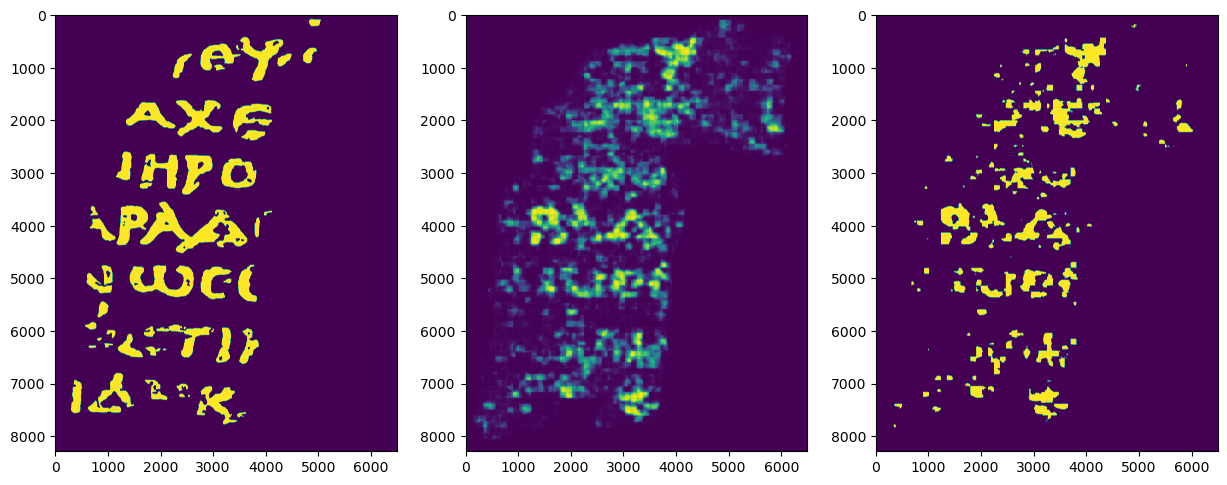

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(valid_mask_gt)
axes[1].imshow(mask_pred)
axes[2].imshow((mask_pred>=best_th).astype(int))

(array([41393082.,  2435435.,  1560192.,  1170567.,   938740.,   772700.,
          675756.,   639033.,   589457.,   534864.,   454829.,   423254.,
          396767.,   340350.,   303064.,   282575.,   270741.,   245382.,
          235594.,   176466.]),
 array([7.91738582e-07, 4.99019820e-02, 9.98031723e-02, 1.49704363e-01,
        1.99605553e-01, 2.49506743e-01, 2.99407934e-01, 3.49309124e-01,
        3.99210314e-01, 4.49111504e-01, 4.99012695e-01, 5.48913885e-01,
        5.98815075e-01, 6.48716266e-01, 6.98617456e-01, 7.48518646e-01,
        7.98419837e-01, 8.48321027e-01, 8.98222217e-01, 9.48123407e-01,
        9.98024598e-01]),
 <BarContainer object of 20 artists>)

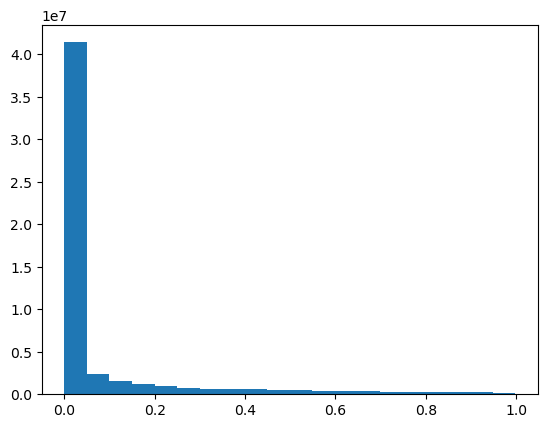

In [38]:
plt.hist(mask_pred.flatten(), bins=20)

In [39]:
# GPU VRAM 5.2GB/16.0GB A4000